untersuche, ob das Fehlen eines bestimmten digits an einer bestimmten Stelle in allen trainingsdaten
Auswirkungen hat

In [1]:
# add parent dir to syspath
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

In [2]:
from models.cyclegan_modified.cyclegan import cyclegan
from imageGenerators import load_realdata
from imageGenerators.imgGen_augmented import synth_generator as synth_generator_new
from FID import FID_interface

import tensorflow as tf
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import time
import pickle
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
n_digits = 5
missing_digit = 3
missing_digit_index = 3

BATCH_SIZE = 1
BUFFER_SIZE = 1000
N_IMAGES = 512
N_IMAGES_FID = 1000
poolsize = 0
adversial_lossfunction = "bce" # either mse or bce
_lambda = 10 # weight of cycleloss
EPOCHS = 3
lr=0.0002

CHECKPOINTPATH = Path("D:/m2/savedmodels/goals/out_of_vocab/512_2/remove%dat%d" % (missing_digit,missing_digit_index) )
IMAGE_DIMENSIONS = (512, 128)
IMAGE_SHAPE = (IMAGE_DIMENSIONS[1], IMAGE_DIMENSIONS[0], 1)

In [4]:
def generateSynthImages():
    # prepare labels_synth
    labels_synth = np.random.randint(0,20,(N_IMAGES, n_digits))
    # replace every digit at missing_digit_index where digit==missing_digit
    for i in range(len(labels_synth)):
        while labels_synth[i, missing_digit_index] == missing_digit :
            labels_synth[i, missing_digit_index] = np.random.randint(0,20,(1))
    for label in labels_synth:
        assert label[missing_digit_index] != missing_digit
    
    # generate synthImages
    synthGenerator = synth_generator_new()
    images_synth = synthGenerator.makeImages(labels_synth, resizeTo=IMAGE_DIMENSIONS, color=True, rotate=True)
    
    # sample-labels where each label consists of only one digit, for each digit
    labels_sample = [
            [digit for _ in range(n_digits)]
            for digit in range(20)
        ]
    images_synth_sample = synthGenerator.makeImages(labels_sample, resizeTo=IMAGE_DIMENSIONS, color=True, rotate=True)
    return (images_synth, labels_synth, images_synth_sample)

In [5]:
def loadAndFilter_realImages():
    # load real easy_samples
    images_easy, labels_easy = load_realdata.load_wmr_easy(resizeTo=IMAGE_DIMENSIONS)
    # remove all images where digit to be removed is contained
    digitOfInterest = np.array([label[missing_digit_index] for label in labels_easy])
    indices = np.where(digitOfInterest != missing_digit)
    
    images_easy_filtered = images_easy[indices]
    labels_easy_filtered = labels_easy[indices]
    
    for label in labels_easy_filtered:
        assert label[missing_digit_index] != missing_digit
        
    images_easy_filtered = images_easy_filtered[0:N_IMAGES]
    labels_easy_filtered = labels_easy_filtered[0:N_IMAGES]
    assert len(images_easy_filtered) == N_IMAGES and len(labels_easy_filtered) == N_IMAGES
    return (images_easy_filtered, labels_easy_filtered)

In [6]:
def train_model():
    print("creating new folder and starting training")
    # create folder
    CHECKPOINTPATH.mkdir()
    # init traindata
    images_synth, labels_synth, images_synth_sample = generateSynthImages()
    images_easy_filtered, labels_easy_filtered = loadAndFilter_realImages()
    # save trainlabels
    labelPath = CHECKPOINTPATH / "training_labels.pickle"
    with open(labelPath, "wb") as picklefile:
        pickle.dump( (labels_synth, labels_easy_filtered), picklefile, pickle.HIGHEST_PROTOCOL)
    # init cgan and train
    cgModel = cyclegan(image_shape=IMAGE_SHAPE,
                   n_images=N_IMAGES,
                   batchsize=BATCH_SIZE,
                   adversial_loss=adversial_lossfunction,
                   lr=lr,
                   _lambda=_lambda,
                   poolsize=poolsize,
                   checkpoint_path=CHECKPOINTPATH
                  )
    # make datasets
    def images2dataset(images):
        return tf.data.Dataset.from_tensor_slices(images) \
            .map(cgModel.preprocess_input, num_parallel_calls=AUTOTUNE) \
            .cache() \
            .batch(BATCH_SIZE)
    train_A = images2dataset(images_synth)
    train_B = images2dataset(images_easy_filtered)
    sample_A = images2dataset(images_synth_sample)
    
    cgModel.train(train_A, train_B, sample_A, epochs=EPOCHS, epochs_before_save=1)

In [7]:
def translate_images(synthImages, i2i_model):
    model_input = tf.data.Dataset.from_tensor_slices(synthImages)\
                .map(i2i_model.preprocess_input, num_parallel_calls=AUTOTUNE)\
                .cache()\
                .batch(1)
    ####
    # predict realistic images
    translated_images = i2i_model.gen_AtoB.predict(model_input)
    # denormalize
    translated_images = (translated_images + 1) * 127.5
    return translated_images

In [8]:
# load cgan-model, generate an imageset inside vocab and one outside vocab.
# calc fids
def loadModel_calcFIDs(epoch_to_load):
    cgModel = cyclegan(image_shape=IMAGE_SHAPE,
                   n_images=N_IMAGES,
                   batchsize=BATCH_SIZE,
                   adversial_loss=adversial_lossfunction,
                   lr=lr,
                   _lambda=_lambda,
                   poolsize=poolsize,
                   checkpoint_path=CHECKPOINTPATH,
                   load_checkpoint_after_epoch=epoch_to_load
                  )
    ####
    # construct 3 different test-datasets
    ###
    # this testdataset should contain every digit at every place
    labels_test_base = np.random.randint(0,20, (N_IMAGES_FID, n_digits) )
    # count how often base contains digit not in trainset
    digitAtIndex_base = np.array([label[missing_digit_index] for label in labels_test_base])
    digit_count = np.count_nonzero(digitAtIndex_base == missing_digit)
    #print(digit_count)
        
    
    ###
    # this testdataset never contains the digit missing in trainset
    labels_test_missing = labels_test_base.copy()
    for label in labels_test_missing:        
        while label[missing_digit_index] == missing_digit :
            label[missing_digit_index] = np.random.randint(0,20,(1))
            
    ###
    # this testdataset always contains the digit missing in trainset
    labels_test_forced = labels_test_base.copy()
    for label in labels_test_forced:
        label[missing_digit_index] = missing_digit
    """
    # labels containing missing digit
    labels_outsideVocab = np.random.randint(0,20, (N_IMAGES_FID, n_digits) )
    for label in labels_outsideVocab:
        # make sure label has missing digit
        label[missing_digit_index] = missing_digit
        
    # labels not containing missing digit
    labels_insideVocab = np.random.randint(0,20, (N_IMAGES_FID, n_digits) )
    for label in labels_insideVocab:
        # make sure label has not missing digit
        while label[missing_digit_index] == missing_digit :
            label[missing_digit_index] = np.random.randint(0,20,(1))
    """
    # generate synthetic images
    synthGenerator = synth_generator_new()
    
    synthethic_base = synthGenerator.makeImages(labels_test_base, resizeTo=IMAGE_DIMENSIONS, color=True, rotate=True)
    synthethic_missing = synthGenerator.makeImages(labels_test_missing, resizeTo=IMAGE_DIMENSIONS, color=True, rotate=True)
    synthethic_forced = synthGenerator.makeImages(labels_test_forced, resizeTo=IMAGE_DIMENSIONS, color=True, rotate=True)
    
    #synth_outsideVocab = synthGenerator.makeImages(labels_outsideVocab, resizeTo=IMAGE_DIMENSIONS, color=True, rotate=True)
    #synth_insideVocab = synthGenerator.makeImages(labels_insideVocab, resizeTo=IMAGE_DIMENSIONS, color=True, rotate=True)
    # translate images
    generated_base = translate_images(synthethic_base, cgModel)
    generated_missing = translate_images(synthethic_missing, cgModel)
    generated_forced = translate_images(synthethic_forced, cgModel)
    #images_outsideVocab = translate_images(synth_outsideVocab, cgModel)
    #images_insideVocab = translate_images(synth_insideVocab, cgModel)
    
    # load real images         
    images_easy, labels_easy = load_realdata.load_wmr_easy(n_toLoad=N_IMAGES_FID, resizeTo=IMAGE_DIMENSIONS)
    # filter out the missing digit from real images
    filter_indices = np.array([label[missing_digit_index] for label in labels_easy])
    filter_indices = np.where(filter_indices != missing_digit)
    images_easy_filtered = images_easy[filter_indices]
    # show generated images
    print("generated base-images:")
    for i in range(5):
        image = generated_base[i,:,:,0] 
        plt.imshow(image, cmap="gray")
        plt.show()
    print("generated missing-images:")
    for i in range(5):
        image = generated_missing[i,:,:,0] 
        plt.imshow(image, cmap="gray")
        plt.show()
    print("generated forced-images:")
    for i in range(5):
        image = generated_forced[i,:,:,0] 
        plt.imshow(image, cmap="gray")
        plt.show()
    
    # calc fids
    gen_base_stats = FID_interface.calculate_stats(generated_base)
    gen_missing_stats = FID_interface.calculate_stats(generated_missing)
    gen_forced_stats = FID_interface.calculate_stats(generated_forced)
    
    #inVocab_stats = FID_interface.calculate_stats(images_insideVocab)
    #outsideVocab_stats = FID_interface.calculate_stats(images_outsideVocab)
    real_stats = FID_interface.calculate_stats(images_easy)
    realFiltered_stats = FID_interface.calculate_stats(images_easy_filtered)
    
    fid_base_real = FID_interface.calculate_fid_from_stats(gen_base_stats, real_stats)
    fid_missing_real = FID_interface.calculate_fid_from_stats(gen_missing_stats, real_stats)
    fid_forced_real = FID_interface.calculate_fid_from_stats(gen_forced_stats, real_stats)
    
    fid_base_realF = FID_interface.calculate_fid_from_stats(gen_base_stats, realFiltered_stats)
    fid_missing_realF = FID_interface.calculate_fid_from_stats(gen_missing_stats, realFiltered_stats)
    fid_forced_realF = FID_interface.calculate_fid_from_stats(gen_forced_stats, realFiltered_stats)
    
    fids = [
        ("base,real)", fid_base_real),
        ("missing,real)", fid_missing_real),
        ("forced,real)", fid_forced_real),
        ("base,realF)", fid_base_realF),
        ("missing,realF)", fid_missing_realF),
        ("forced,realF)", fid_forced_realF),
    ]
        
    
    for fid in fids:
        print("fid(%s) =\t%f" % (fid[0],fid[1]) )
        
    print("len(realF): %d" % (len(images_easy_filtered)) )
    
    
    
    """
    fid_in_Real = FID_interface.calculate_fid_from_stats(inVocab_stats, real_stats)
    fid_outside_Real = FID_interface.calculate_fid_from_stats(outsideVocab_stats, real_stats)
    fid_in_outside = FID_interface.calculate_fid_from_stats(inVocab_stats, outsideVocab_stats)
    
    fid_in_realFiltered_stats = FID_interface.calculate_fid_from_stats(inVocab_stats, realFiltered_stats)
    fid_outside_realFiltered_stats = FID_interface.calculate_fid_from_stats(outsideVocab_stats, realFiltered_stats)
    fid_real_realFiltered_stats = FID_interface.calculate_fid_from_stats(real_stats, realFiltered_stats)
    
    print("fid(in,real:\t%d)" % (fid_in_Real) ) 
    print("fid(out,real:\t%d)" % (fid_outside_Real) ) 
    print("fid(in,out:\t%d)" % (fid_in_outside) ) 
    
    print("fid(in,realFiltered:\t%d)" % (fid_in_realFiltered_stats) ) 
    print("fid(out,realFiltered:\t%d)" % (fid_outside_realFiltered_stats) ) 
    print("fid(real,realFiltered:\t%d)" % (fid_real_realFiltered_stats) )
    """
    

loaded checkpoint:  D:\m2\savedmodels\goals\out_of_vocab\512_2\remove3at3\epoch-1


C:\Users\andre\jupyter_ws\imageGenerators\load_realdata.py:57: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(txt_path, sep=seperators ,header=None)


generated base-images:


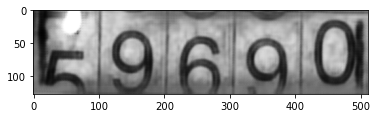

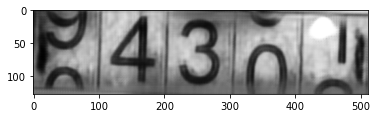

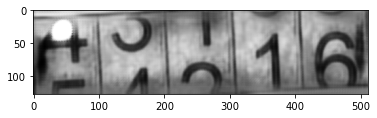

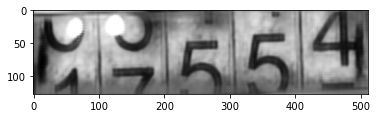

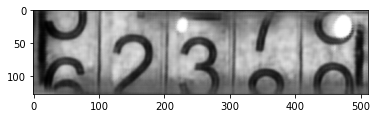

generated missing-images:


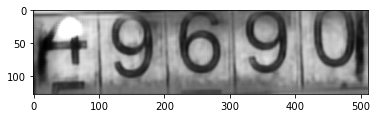

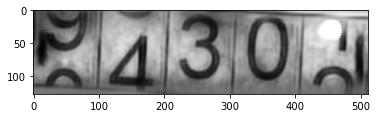

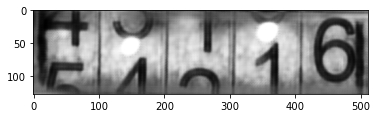

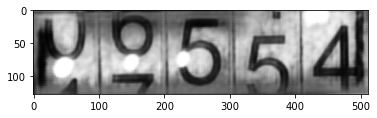

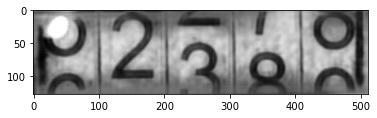

generated forced-images:


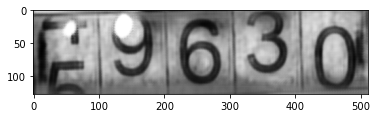

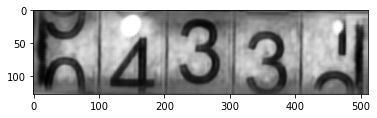

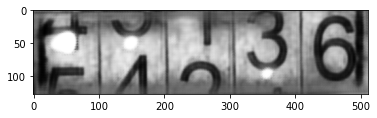

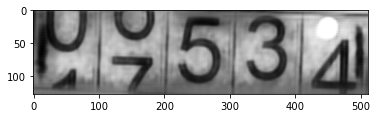

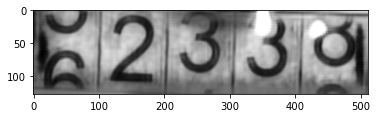

fid(base,real)) =	139.947798
fid(missing,real)) =	141.492286
fid(forced,real)) =	106.043012
fid(base,realF)) =	137.729217
fid(missing,realF)) =	139.380404
fid(forced,realF)) =	105.038764
len(realF): 915


In [9]:
#####
# MAIN
#####
# train if path not existing,
# else calc FID
if not CHECKPOINTPATH.exists():
    train_model()    
else:
    loadModel_calcFIDs(1)